In [1]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pathlib import Path
import numpy as np

BASE_DIR = Path.cwd().parent

features  =pd.read_csv(f'{BASE_DIR}/data/features_test.csv')

excluded_features = ['account_uuid', 'state', 'business_structure','industry', 'subindustry',  'index','account_value']
feature_columns = list(set(features.columns) - set(excluded_features))
X = features[feature_columns]
#y = features['account_value']

/home/yuttokb/.cache/pypoetry/virtualenvs/challenge-coverwallet-elSskqz9-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = joblib.load(f'{BASE_DIR}/model/xgboost_model.joblib')

In [3]:
# Run this in your training script to see how many features you have
print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist() if hasattr(X, 'columns') else 'No names'}")

Number of features: 39
Feature names: ['carrier_concentration', 'max_x_nquotes', 'revenue_per_employee', 'premium_range', 'quotes_per_million_revenue', 'avg_x_nproducts', 'product_concentration', 'premium_per_quote', 'industry_revenue_encoded', 'num_carriers', 'num_quotes', 'quotes_per_employee', 'total_quotes', 'state_revenue_encoded', 'sum_premium', 'iqr_premium', 'industry_sum_premium_encoded', 'premium_per_employee', 'state_premium_sum_encoded', 'business_structure_premium_sum_encoded', 'carrier_diversity', 'log_total_payroll', 'premium_to_revenue_ratio', 'business_structure_revenue_encoded', 'num_employees', 'annual_revenue', 'log_annual_revenue', 'revenue_x_payroll', 'subindustry_sum_premium_encoded', 'num_products_requested', 'min_premium', 'premium_ratio_max_avg', 'premium_per_revenue', 'max_premium', 'subindustry_revenue_encoded', 'region', 'year_established', 'total_payroll', 'avg_premium']


In [4]:
expected_features = model.feature_names_in_ 

In [5]:
expected_features = model.feature_names_in_  # o model.get_booster().feature_names

# Reordenar X para que coincida exactamente
X_ordered = X[expected_features]

# Ahora predecir
y_pred = model.predict(X_ordered)


In [6]:
features['account_value'] = y_pred

In [7]:
features[['account_uuid','account_value']].to_csv(f'{BASE_DIR}/data/predictions_old.csv', index=False)

In [8]:
expected_features = model.feature_names_in_  # o model.get_booster().feature_names

# Reordenar X para que coincida exactamente
X_ordered = X[expected_features]

# Ahora predecir
y_pred = model.predict(X_ordered)


features['y_pred'] = y_pred


features['diff'] = np.abs(features['y_pred'] - features['account_value'])
features['diff_perc'] = np.abs(features['y_pred'] - features['account_value'])/features['account_value'] * 100

features[['account_value','y_pred','diff','diff_perc']].sort_values(by='diff', ascending=False).head(10)

,account_value,y_pred,diff,diff_perc
0,1306.925293,1306.925293,0.0,0.0
1,1499.133179,1499.133179,0.0,0.0
2,1575.308838,1575.308838,0.0,0.0
3,437.792389,437.792389,0.0,0.0
4,4536.324219,4536.324219,0.0,0.0
5,1633.651855,1633.651855,0.0,0.0
6,3885.864258,3885.864258,0.0,0.0
7,805.902954,805.902954,0.0,0.0
8,2574.989014,2574.989014,0.0,0.0
9,1241.181030,1241.181030,0.0,0.0


In [9]:
len(features[features['diff_perc']>25])/len(features)

0.0

In [10]:
# Calcular errores relativos
features['error_pct'] = np.abs(features['y_pred'] - features['account_value']) / features['account_value'] * 100
features['high_error'] = features['error_pct'] > 25

# Analizar por segmentos
print("% de errores altos por segmento:")
for col in ['industry', 'region', 'business_structure']:  # ajustar nombres
    if col in features.columns:
        error_by_segment = features.groupby(col)['high_error'].mean() * 100
        print(f"\n{col}:")
        print(error_by_segment.sort_values(ascending=False))

% de errores altos por segmento:

industry:
industry
Administrative Services and Building Maintenance    0.0
Agriculture, Forestry, Fishing and Hunting          0.0
Construction                                        0.0
Consultants                                         0.0
Contractors                                         0.0
Education                                           0.0
Finance and Insurance                               0.0
Food and Accommodation                              0.0
Healthcare                                          0.0
Manufacturing                                       0.0
Non Profits                                         0.0
Other Services                                      0.0
Professional, Scientific and Technical Services     0.0
Real Estate                                         0.0
Retail Trade                                        0.0
Sports, Arts, Entertainment, and Recreation         0.0
Technology, Media and Telecommunications           

In [11]:


importances = pd.DataFrame({
    'feature': X[expected_features].columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)



In [12]:
importances

,feature,importance
25,avg_x_nproducts,0.150477
8,premium_per_employee,0.107791
12,log_annual_revenue,0.086467
28,max_premium,0.071176
27,premium_per_quote,0.068744
30,avg_premium,0.067094
13,premium_to_revenue_ratio,0.041426
16,annual_revenue,0.039956
10,num_quotes,0.031968
7,business_structure_revenue_encoded,0.027497


In [13]:
# Para un cliente específico
import shap

# Tu modelo entrenado
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_ordered)

# Para un cliente específico (índice 0)
print("Predicción base (promedio):", explainer.expected_value)
print("Predicción real:", model.predict(X_ordered.iloc[[0]])[0])
print("SHAP values:")
for feature, shap_val in zip(X_ordered.columns, shap_values[0]):
    print(f"  {feature}: {shap_val:+.2f}")

Predicción base (promedio): 1723.7832
Predicción real: 1306.9253
SHAP values:
  log_total_payroll: +26.45
  year_established: +3.39
  total_payroll: +34.01
  product_concentration: -30.12
  state_premium_sum_encoded: +6.43
  subindustry_sum_premium_encoded: -3.00
  carrier_concentration: +20.03
  business_structure_revenue_encoded: +0.03
  premium_per_employee: -6.72
  industry_revenue_encoded: -4.20
  num_quotes: +4.66
  revenue_x_payroll: -39.44
  log_annual_revenue: +10.13
  premium_to_revenue_ratio: -22.58
  total_quotes: -5.25
  premium_ratio_max_avg: -10.50
  annual_revenue: +1.09
  max_x_nquotes: +9.57
  state_revenue_encoded: -1.71
  num_employees: +3.58
  business_structure_premium_sum_encoded: +0.00
  industry_sum_premium_encoded: -13.67
  num_products_requested: -17.06
  iqr_premium: +35.00
  premium_per_revenue: +1.80
  avg_x_nproducts: -348.39
  subindustry_revenue_encoded: -3.72
  premium_per_quote: -116.05
  max_premium: +35.54
  quotes_per_million_revenue: +6.58
  avg_p

Predicción base (promedio): 1723.7832
Predicción real: 1306.9253


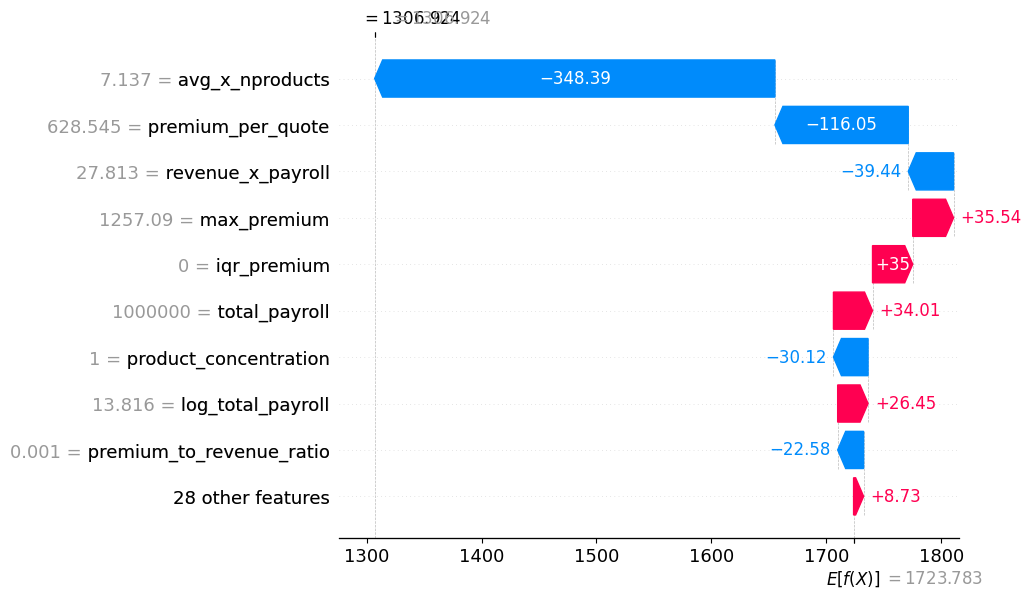

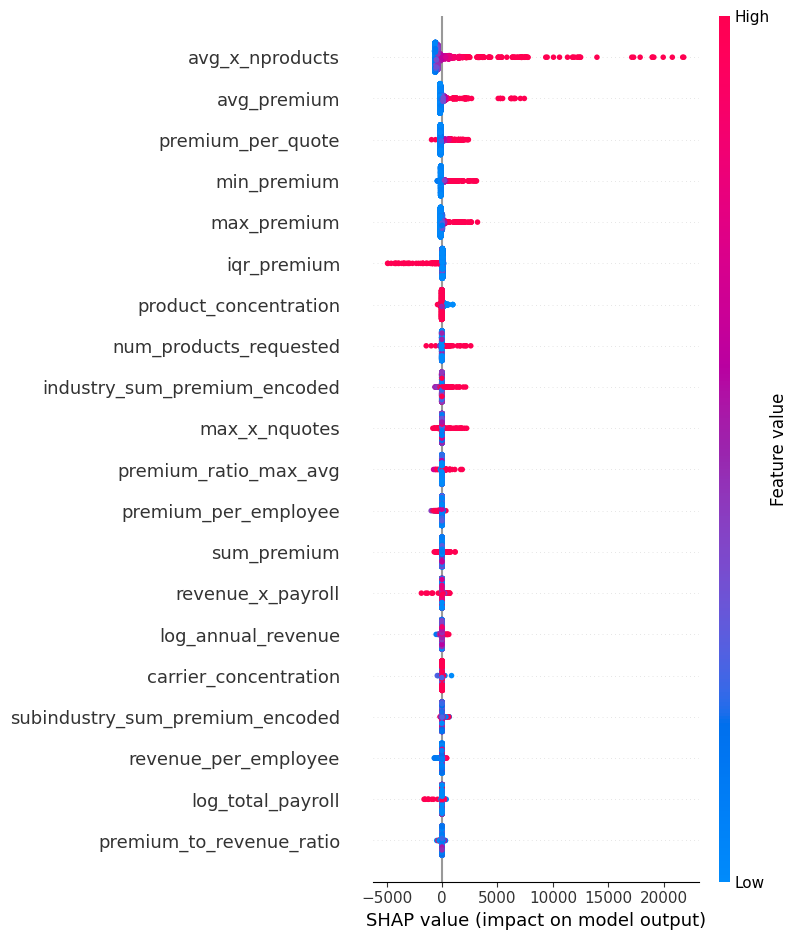

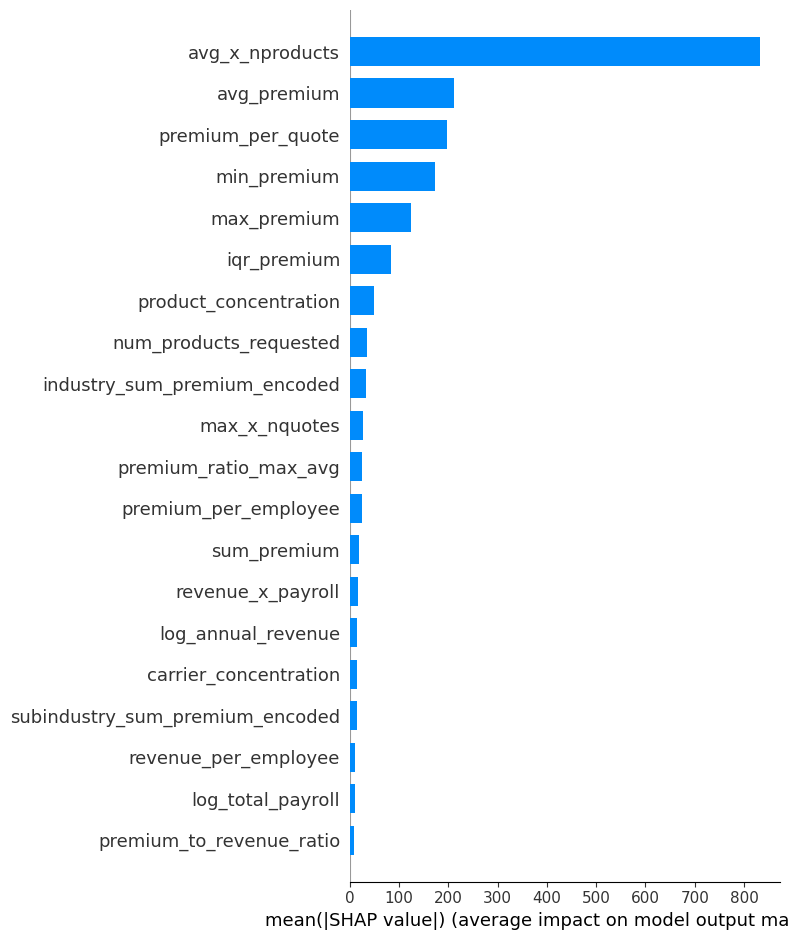

<Figure size 1400x800 with 0 Axes>

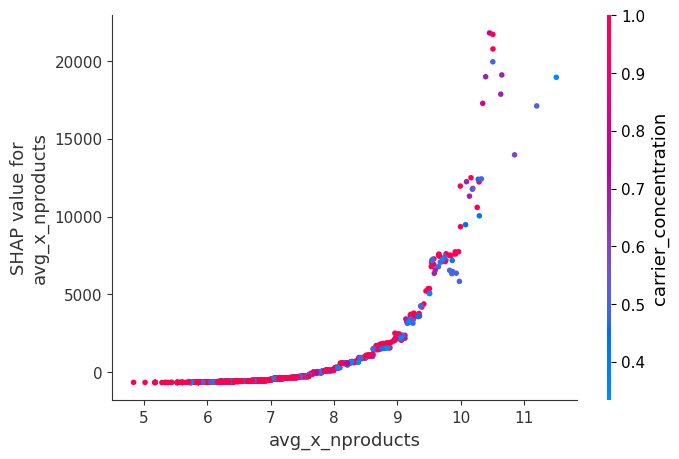

In [14]:
import shap
import matplotlib.pyplot as plt

# Tu código base
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_ordered)

print("Predicción base (promedio):", explainer.expected_value)
print("Predicción real:", model.predict(X_ordered.iloc[[0]])[0])

# ===== PLOTS CORREGIDOS =====

# 1. Waterfall plot - VERSIÓN CORRECTA
shap_explanation = explainer(X_ordered)  # Crear objeto Explanation
shap.plots.waterfall(shap_explanation[0])  # Plot para el primer caso
plt.show()

# 2. Force plot - Funciona igual
shap.force_plot(explainer.expected_value, shap_values[0], X_ordered.iloc[0])

# 3. Summary plot - Funciona igual
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_ordered, plot_type="dot")
plt.show()

# 4. Bar plot - Funciona igual  
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_ordered, plot_type="bar")
plt.show()

plt.figure(figsize=(14, 8))
# 5. Dependence plot - Funciona igual
shap.dependence_plot('avg_x_nproducts', shap_values, X_ordered)
plt.show()

